In [16]:
import pandas as pd
import numpy as np
import pybaseball as pyb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, atan2, degrees, pi
from scipy.stats import percentileofscore
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data_2023 = pyb.statcast(start_dt='2023-03-30', end_dt='2023-10-01')

This is a large query, it may take a moment to complete


/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|█████████████████████████████████████████| 186/186 [00:41<00:00,  4.45it/s]


In [3]:
fastballs = data_2023[data_2023['pitch_type'].isin(['FF'])]
fastballs.dropna(subset=['vy0'], inplace=True)
fastballs.dropna(subset=['release_extension'], inplace=True)
fastballs.dropna(subset=['spin_axis'], inplace=True)

/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [4]:
def calculate_vaa(row):
    yf = 17/12  # Home plate distance in feet, converted to inches
    ay = row['ay']  # Acceleration in y-dimension for the current pitch
    vy0 = row['vy0']  # Velocity in y-dimension at y=50 feet for the current pitch
    vz0 = row['vz0']  # Velocity in z-dimension at y=50 feet for the current pitch
    az = row['az']  # Acceleration in z-dimension for the current pitch

    vy_f = -sqrt(vy0**2 - (2 * ay * (50 - yf)))
    t = (vy_f - vy0) / ay
    vz_f = vz0 + (az * t)
    vaa_rad = atan2(vz_f, vy_f)
    vaa_deg = (180+degrees(vaa_rad))*-1

    return vaa_deg
fastballs['VAA'] = fastballs.apply(calculate_vaa, axis=1)

/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_33029/716655449.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['VAA'] = fastballs.apply(calculate_vaa, axis=1)


In [5]:
def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA

In [6]:
filtered_ff = fastballs.loc[:, ['pitcher','type','ax','ay','az','release_pos_z', 'player_name', 'pfx_z', 'release_spin_rate','plate_x','spin_axis','VAA','release_extension','zone','plate_z','release_speed','release_pos_x','release_pos_y','vx0','vy0','vz0']]

In [7]:
filtered_ff['VRA'] = filtered_ff.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['release_extension'], x['vz0'], x['az']), axis=1)
filtered_ff['HRA'] = filtered_ff.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['release_extension'], x['vx0'], x['ax']), axis=1)

In [8]:
pitch_count = filtered_ff['pitcher'].value_counts()

filtered_ff_filtered = filtered_ff[filtered_ff['pitcher'].isin(pitch_count.index[pitch_count >= 400])]

In [9]:
grouped_ff = filtered_ff_filtered.groupby('pitcher').agg({
    'player_name': 'first',  
    'VRA': 'std',
    'HRA': 'std',
    'release_pos_z': 'std',
    'release_pos_x': 'std',
    'type': lambda x: (x == 'S').sum() / len(x)  
}).reset_index()  

# Rename the column to 'strike_rate'
grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)

In [10]:
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'release_pos_z': 0.17, 'release_pos_x': 0.14}

grouped_ff['VRA_percentile'] = 1 - grouped_ff['VRA'].rank(pct=True)
grouped_ff['HRA_percentile'] = 1 - grouped_ff['HRA'].rank(pct=True)
grouped_ff['release_pos_z_percentile'] = 1 - grouped_ff['release_pos_z'].rank(pct=True)
grouped_ff['release_pos_x_percentile'] = 1 - grouped_ff['release_pos_x'].rank(pct=True)

grouped_ff['kirby_index'] = (
    grouped_ff['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_ff['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_ff['release_pos_z_percentile'] * weights['release_pos_z'] +
    grouped_ff['release_pos_x_percentile'] * weights['release_pos_x']
)

ranked_pitchers_weighted = grouped_ff.sort_values('kirby_index', ascending=False)


In [11]:
fangraphs_2023 = pd.read_excel('/Users/michaelrosen/Desktop/Sports/Baseball/Fantasy_2024/fangraphs_excel_2023.xlsx')

In [12]:
merge_df = grouped_ff.merge(fangraphs_2023, left_on = 'pitcher',right_on = 'MLBAMID')

In [20]:
merge_df.dropna(subset=['botCmd FA'], inplace=True)

R-squared: 0.19857665642096356


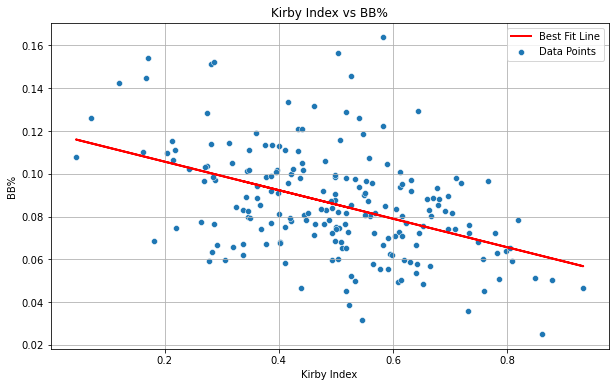

In [21]:
y = merge_df['BB%'].values.reshape(-1, 1)
x = merge_df['kirby_index'].values

model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
r_squared = r2_score(y, model.predict(x.reshape(-1, 1)))
print("R-squared:", r_squared)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merge_df, x='kirby_index', y='BB%')
plt.plot(x, model.predict(x.reshape(-1, 1)), color='red', linewidth=2)
plt.title('Kirby Index vs BB%')
plt.xlabel('Kirby Index')
plt.ylabel('BB%')
plt.legend(['Best Fit Line', 'Data Points'])
plt.grid(True)
plt.show()


R-squared: 0.4012087802217328


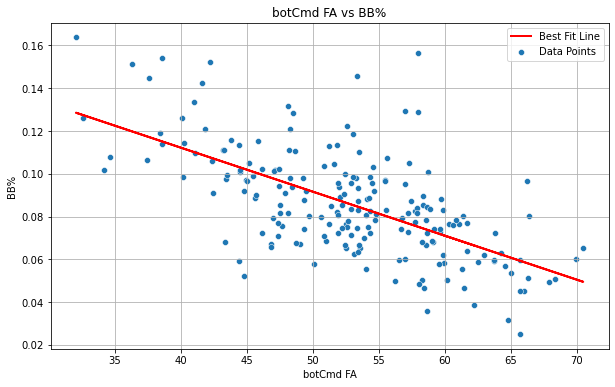

In [22]:
y = merge_df['BB%'].values.reshape(-1, 1)
x = merge_df['botCmd FA'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)
r_squared = r2_score(y, model.predict(x))
print("R-squared:", r_squared)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merge_df, x='botCmd FA', y='BB%')
plt.plot(x, model.predict(x), color='red', linewidth=2)
plt.title('botCmd FA vs BB%')
plt.xlabel('botCmd FA')
plt.ylabel('BB%')
plt.legend(['Best Fit Line', 'Data Points'])
plt.grid(True)
plt.show()


R-squared: 0.4741455216713264


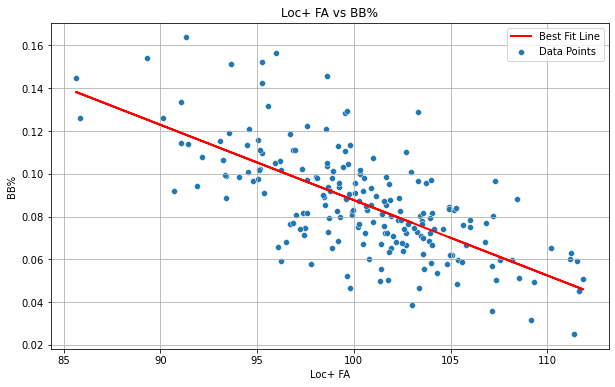

In [23]:
y = merge_df['BB%'].values.reshape(-1, 1)
x = merge_df['Loc+ FA'].values.reshape(-1, 1)

model = LinearRegression()
model.fit(x, y)
r_squared = r2_score(y, model.predict(x))
print("R-squared:", r_squared)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merge_df, x='Loc+ FA', y='BB%')
plt.plot(x, model.predict(x), color='red', linewidth=2)
plt.title('Loc+ FA vs BB%')
plt.xlabel('Loc+ FA')
plt.ylabel('BB%')
plt.legend(['Best Fit Line', 'Data Points'])
plt.grid(True)
plt.show()


In [24]:
x_loc_fa = merge_df['Loc+ FA'].values.reshape(-1, 1)
x_botcmd_fa = merge_df['botCmd FA'].values.reshape(-1, 1)
x_kirby_index = merge_df['kirby_index'].values.reshape(-1, 1)
y_hr9 = merge_df['HR/9'].values.reshape(-1, 1)

model_loc_fa = LinearRegression()
model_loc_fa.fit(x_loc_fa, y_hr9)
r2_loc_fa = r2_score(y_hr9, model_loc_fa.predict(x_loc_fa))

model_botcmd_fa = LinearRegression()
model_botcmd_fa.fit(x_botcmd_fa, y_hr9)
r2_botcmd_fa = r2_score(y_hr9, model_botcmd_fa.predict(x_botcmd_fa))

model_kirby_index = LinearRegression()
model_kirby_index.fit(x_kirby_index, y_hr9)
r2_kirby_index = r2_score(y_hr9, model_kirby_index.predict(x_kirby_index))

print("R-squared for Loc+ FA with HR/9:", r2_loc_fa)
print("R-squared for botCmd FA with HR/9:", r2_botcmd_fa)
print("R-squared for kirby_index with HR/9:", r2_kirby_index)


R-squared for Loc+ FA with HR/9: 0.017793809712801312
R-squared for botCmd FA with HR/9: 0.006008832610708725
R-squared for kirby_index with HR/9: 4.387644281567127e-05


In [25]:
run_values = pd.read_excel('/Users/michaelrosen/Desktop/Sports/Baseball/Fantasy_2024/wfa_c.xlsx')

In [26]:
merge_df = merge_df.merge(run_values,on='MLBAMID')

In [27]:
x_loc_fa = merge_df['Loc+ FA'].values.reshape(-1, 1)
x_botcmd_fa = merge_df['botCmd FA'].values.reshape(-1, 1)
x_kirby_index = merge_df['kirby_index'].values.reshape(-1, 1)
y_wfa_c = merge_df['wFA/C'].values.reshape(-1, 1)

model_loc_fa = LinearRegression()
model_loc_fa.fit(x_loc_fa, y_wfa_c)
r2_loc_fa = r2_score(y_wfa_c, model_loc_fa.predict(x_loc_fa))

model_botcmd_fa = LinearRegression()
model_botcmd_fa.fit(x_botcmd_fa, y_wfa_c)
r2_botcmd_fa = r2_score(y_wfa_c, model_botcmd_fa.predict(x_botcmd_fa))

model_kirby_index = LinearRegression()
model_kirby_index.fit(x_kirby_index, y_wfa_c)
r2_kirby_index = r2_score(y_wfa_c, model_kirby_index.predict(x_kirby_index))

print("R-squared for Loc+ FA with wFA/C:", r2_loc_fa)
print("R-squared for botCmd FA with wFA/C:", r2_botcmd_fa)
print("R-squared for kirby_index with wFA/C:", r2_kirby_index)


R-squared for Loc+ FA with wFA/C: 0.07628366040118106
R-squared for botCmd FA with wFA/C: 0.06927501026104943
R-squared for kirby_index with wFA/C: 0.03555312822938883


In [28]:
x_loc_fa = merge_df['Loc+ FA'].values.reshape(-1, 1)
x_botcmd_fa = merge_df['botCmd FA'].values.reshape(-1, 1)
x_kirby_index = merge_df['kirby_index'].values.reshape(-1, 1)
y_strike_rate = merge_df['strike_rate'].values.reshape(-1, 1)

model_loc_fa = LinearRegression()
model_loc_fa.fit(x_loc_fa, y_strike_rate)
r2_loc_fa = r2_score(y_strike_rate, model_loc_fa.predict(x_loc_fa))

model_botcmd_fa = LinearRegression()
model_botcmd_fa.fit(x_botcmd_fa, y_strike_rate)
r2_botcmd_fa = r2_score(y_strike_rate, model_botcmd_fa.predict(x_botcmd_fa))

model_kirby_index = LinearRegression()
model_kirby_index.fit(x_kirby_index, y_strike_rate)
r2_kirby_index = r2_score(y_strike_rate, model_kirby_index.predict(x_kirby_index))

print("R-squared for Loc+ FA with strike_rate:", r2_loc_fa)
print("R-squared for botCmd FA with strike_rate:", r2_botcmd_fa)
print("R-squared for kirby_index with strike_rate:", r2_kirby_index)


R-squared for Loc+ FA with strike_rate: 0.407330562800042
R-squared for botCmd FA with strike_rate: 0.44170858375545285
R-squared for kirby_index with strike_rate: 0.19002005477387007


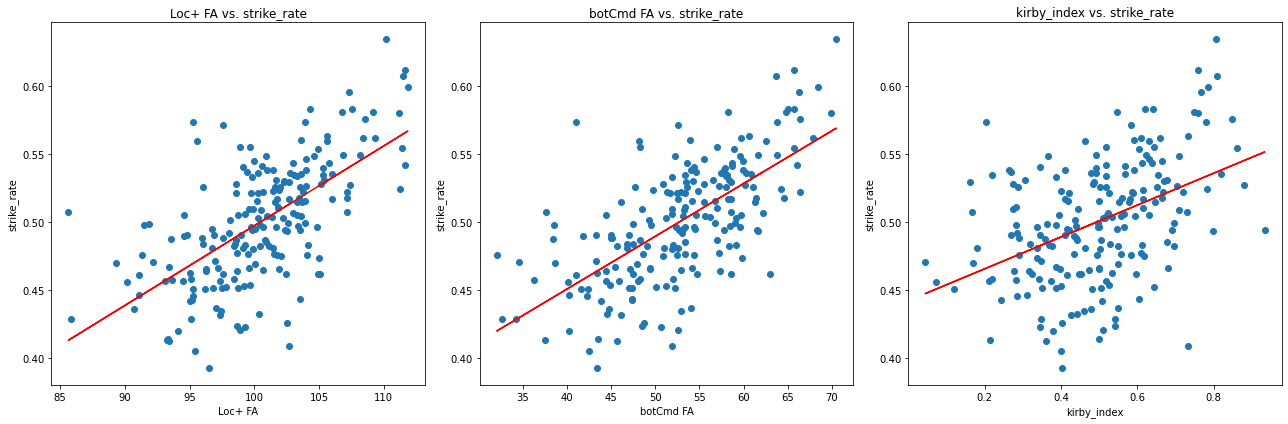

In [29]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(merge_df['Loc+ FA'], merge_df['strike_rate'])
model_loc_fa = LinearRegression()
model_loc_fa.fit(merge_df['Loc+ FA'].values.reshape(-1, 1), merge_df['strike_rate'])
plt.plot(merge_df['Loc+ FA'], model_loc_fa.predict(merge_df['Loc+ FA'].values.reshape(-1, 1)), color='red')
plt.title('Loc+ FA vs. strike_rate')
plt.xlabel('Loc+ FA')
plt.ylabel('strike_rate')

plt.subplot(1, 3, 2)
plt.scatter(merge_df['botCmd FA'], merge_df['strike_rate'])
model_botcmd_fa = LinearRegression()
model_botcmd_fa.fit(merge_df['botCmd FA'].values.reshape(-1, 1), merge_df['strike_rate'])
plt.plot(merge_df['botCmd FA'], model_botcmd_fa.predict(merge_df['botCmd FA'].values.reshape(-1, 1)), color='red')
plt.title('botCmd FA vs. strike_rate')
plt.xlabel('botCmd FA')
plt.ylabel('strike_rate')

plt.subplot(1, 3, 3)
plt.scatter(merge_df['kirby_index'], merge_df['strike_rate'])
model_kirby_index = LinearRegression()
model_kirby_index.fit(merge_df['kirby_index'].values.reshape(-1, 1), merge_df['strike_rate'])
plt.plot(merge_df['kirby_index'], model_kirby_index.predict(merge_df['kirby_index'].values.reshape(-1, 1)), color='red')
plt.title('kirby_index vs. strike_rate')
plt.xlabel('kirby_index')
plt.ylabel('strike_rate')

plt.tight_layout()
plt.show()
